# Benchmark statistical methods to estimate confidence intervals for the mean on simulated data
**Use case study: Hospital length of stay for the rare disease autoimmune encephalitis**

Steps:
1. Simulate data mimicking the skewed, overdispersed distribution of hospital length of stay for patients with autoimmune encephalitis. 
2. Code snippets to implement three or four different statistical methods to estimate confidence intervals for the mean
   - Method 1: t-distribution method
   - Method 2: z-distribution method
   - Method 3: Bootstrap method
   - Method 4: Bayesian method
3. Compare the performance of the methods using simulation. Performance metrics could include:
   - Coverage probability
   - Length of confidence intervals
4. Visualize summary statistics of performance matrix

The notebook focuses on comparing frequentist methods and does not include Bayesian credible intervals, as they follow a different philosophy and require a distinct interpretation.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

## Simulating data for true population parameters

To make the simulation more realistic, we will use a log-normal distribution to simulate the hospital length of stay. The log-normal distribution is often used to model skewed data, such as hospital length of stay.

The parameters for the log-normal distribution will be set to mimic the characteristics of hospital length of stay for patients with autoimmune encephalitis. Set true population parameters as follows:
- True mean length of stay: 55 days 
- True standard deviation: 20 days
- Sample size: 100,000 patients with anti-NMDA encephalitis


In [3]:
population_n = 10000
mean_true = 55 
sd_true = 20

# Mean and standard deviation in log space
mu = np.log(55)
sigma_squared = np.log(1 + (sd_true**2) / (mean_true**2))
sigma = np.sqrt(sigma_squared)

In [4]:

true_population = np.random.lognormal(mean=mu, sigma=sigma, size=population_n) 

Overview the simulated data in histogram

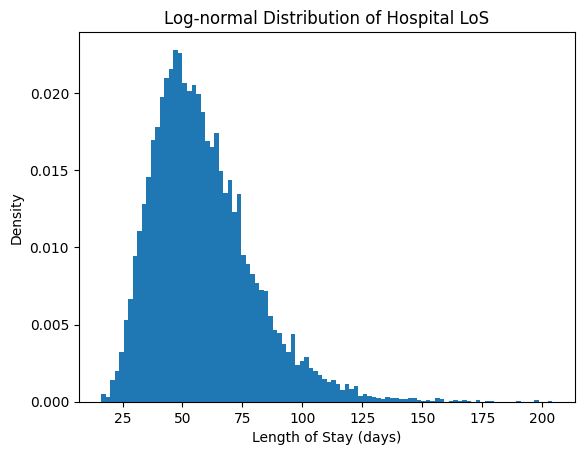

In [5]:
# Overview the simulated population in a histogram
plt.hist(true_population, bins=100, density=True)
plt.title("Log-normal Distribution of Hospital LoS")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Density")
# plt.xlim(0, 100)
plt.show()

### Sampling from a log-normal distribution

Sample randomly from a log-normal distribution with the size of 50 patients. 

In [6]:
np.random.seed(42)
sample_50 = np.random.choice(true_population, size=50, replace=False)

In [7]:
print(f"Sample mean: {np.mean(sample_50):.2f}, SD: {np.std(sample_50):.2f}")

Sample mean: 61.23, SD: 24.36


## Code snippets to implement different statistical methods

### Method 1: t-distribution method

**Formula for t-distribution method:**
$$
CI = \bar{x} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}
$$
Where:
- $\bar{x}$ is the sample mean
- $t_{\alpha/2, n-1}$ is the t-value for a two-tailed test with $\alpha$ level of significance and $n-1$ degrees of freedom
- $s$ is the sample standard deviation
- $n$ is the sample size

In [8]:
# t-distribution CI calculation

sample_n = len(sample_50)
sample_mean = np.mean(sample_50)
sample_sd = np.std(sample_50, ddof=1)
se = sample_sd / np.sqrt(sample_n)
t_crit = stats.t.ppf(0.975, df=sample_n-1) # percent point function 

ci_lower = sample_mean - t_crit * se
ci_upper = sample_mean + t_crit * se

# Print result
print(f"Sample mean = {sample_mean:.2f}")
print(f"95% t-distribution CI: ({ci_lower:.2f}, {ci_upper:.2f})")


Sample mean = 61.23
95% t-distribution CI: (54.24, 68.23)


## Method 2: z-distribution method
**Formula for z-distribution method:**
$$
CI = \bar{x} \pm z_{\alpha/2} \cdot \frac{\sigma}{\sqrt{n}}
$$
Where:
- $\bar{x}$ is the sample mean
- $z_{\alpha/2}$ is the z-value for a two-tailed test with $\alpha$ level of significance
- $\sigma$ is the population standard deviation
- $n$ is the sample size

In [9]:
from scipy.stats import norm

In [10]:
# Z-distribution CI calculation
population_sd = np.std(true_population, ddof=0)
z_se = sample_sd / np.sqrt(sample_n)
z_crit = stats.norm.ppf(0.975) # percent point function\

z_ci_lower = sample_mean - z_crit * z_se
z_ci_upper = sample_mean + z_crit * z_se

# Print result
print(f"Sample mean = {sample_mean:.2f}")
print(f"95% z-distribution CI: ({z_ci_lower:.2f}, {z_ci_upper:.2f})")

Sample mean = 61.23
95% z-distribution CI: (54.41, 68.06)


## Method 3: Bootstrap method

Bootstrap resampling involves:
1. Draw many samples (with replacement) from the observed data.
2. Compute the sample mean for each resample. 
3. Take percentiles (e.g., 2.5th and 97.5th) of those means to form the bootstrap CI.

In [11]:
# Bootstrap 
bootstrap_n = 1000
bootstrap_means = []

for _ in range(bootstrap_n):
    bootstrap_sample = np.random.choice(sample_50, size=50, replace=True)
    bootstrap_means.append(np.mean(bootstrap_sample))

ci_lower  = np.percentile(bootstrap_means, 2.5)
ci_upper = np.percentile(bootstrap_means, 97.5)

print(f"Bootstrap 95% CI for mean: ({ci_lower:.2f}, {ci_upper:.2f})") 

Bootstrap 95% CI for mean: (54.89, 67.83)


# Compare performance of three methods

Next, I will compare three CI estimators in the two key performance matrix, coverage and interval width. 

In theory, the sample size and skewness among a few factors affect accuracy and precision of confidence intervals resulting from a given approach.

The notebook, thus aims to compare three methods performance based on empirical evidence. The sample sizes and skewness include:

In [12]:
# Step 1: Define CI methods
def ci_t(sample):
    n = len(sample)
    m = np.mean(sample)
    se = np.std(sample, ddof=1) / np.sqrt(n)
    t_crit = stats.t.ppf(0.975, df=n-1)
    return m - t_crit * se, m + t_crit * se

def ci_z(sample):
    n = len(sample)
    m = np.mean(sample)
    se = np.std(sample, ddof=1) / np.sqrt(n)
    z_crit = stats.norm.ppf(0.975)
    return m - z_crit * se, m + z_crit * se

def ci_bootstrap(sample, n_bootstraps=1000, ci=0.95):
    n = len(sample)
    means = []

    for _ in range(n_bootstraps):
        resample = np.random.choice(sample, size=n, replace=True)
        means.append(np.mean(resample))

    alpha = 1 - ci
    lower = np.percentile(means, 100 * (alpha / 2))
    upper = np.percentile(means, 100 * (1 - alpha / 2))
    return lower, upper
    



In [13]:
sample_sizes = [10, 30, 100]
skew_levels = [0.4, 0.8, 1.2]
n_reps = 1000

results = []

In [14]:
for skew in skew_levels:
    mu = np.log(20)
    for n in sample_sizes:
        population = np.random.lognormal(mean=mu, sigma=skew, size=100000)
        true_mean = np.mean(population)

        for _ in tqdm.tqdm(range(n_reps), desc=f"σ={skew}, n={n}"):
            sample = np.random.choice(population, size=n, replace=False)

            # t-CI
            t_low, t_high = ci_t(sample)
            # z-CI
            z_low, z_high = ci_z(sample)
            # bootstrap-CI
            b_low, b_high = ci_bootstrap(sample)

            results += [
                {"n": n, "skew": skew, "method": "t", "contains_mean": t_low <= true_mean <= t_high, "width": t_high - t_low},
                {"n": n, "skew": skew, "method": "z", "contains_mean": z_low <= true_mean <= z_high, "width": z_high - z_low},
                {"n": n, "skew": skew, "method": "bootstrap", "contains_mean": b_low <= true_mean <= b_high, "width": b_high - b_low}
            ]

# Summary
df = pd.DataFrame(results)
summary = df.groupby(["n", "skew", "method"]).agg(
    coverage = ("contains_mean", "mean"),
    avg_width = ("width", "mean")
).reset_index()            

            

σ=1.2, n=100: 100%|██████████| 1000/1000 [00:11<00:00, 89.73it/s]


In [15]:
summary.head()

,n,skew,method,coverage,avg_width
0,10,0.4,bootstrap,0.885,9.918591
1,10,0.4,t,0.925,12.238010
2,10,0.4,z,0.900,10.603180
3,10,0.8,bootstrap,0.844,25.977427
4,10,0.8,t,0.885,32.481201


## Visualization of summary statistics of performance matrix

### Coverage probability

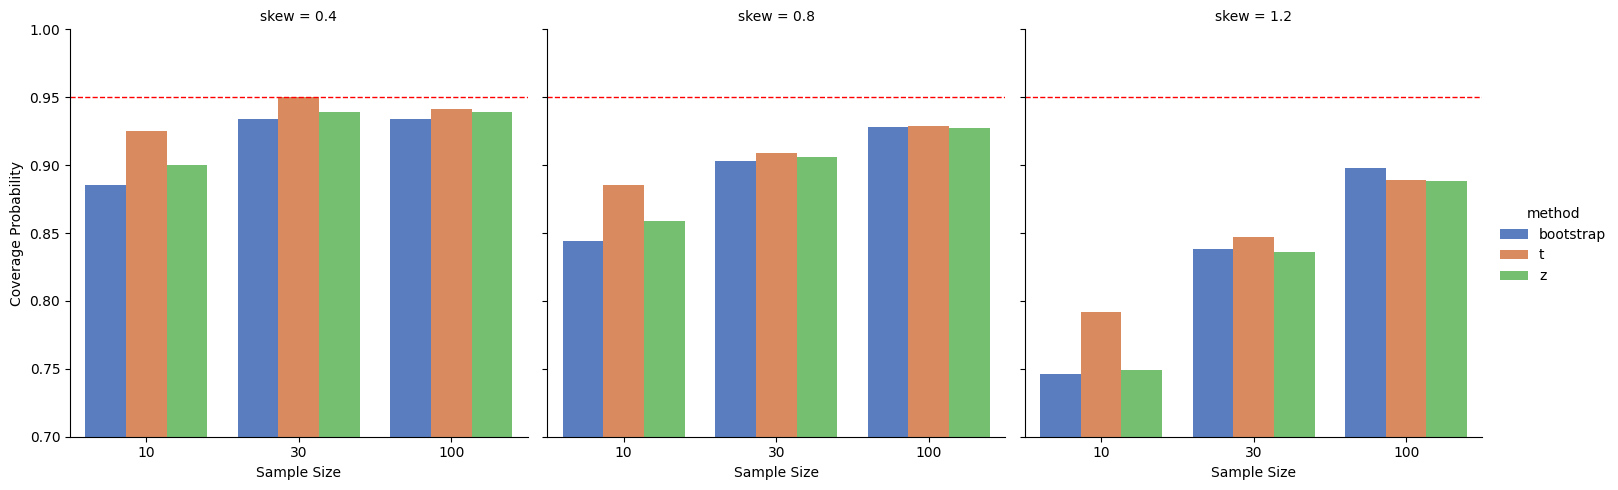

In [24]:
barplot_coverage = sns.catplot(
    data=summary,
    x='n', 
    y='coverage', 
    hue='method',
    col='skew',
    kind='bar',
    palette='muted',
    errorbar=None)

# Adjust y-axis range, e.g., from 0 to 1.1
barplot_coverage.set(ylim=(0.7, 1.0))

# Add horizontal reference line at y=0.95
for ax in barplot_coverage.axes.flat:
    ax.axhline(0.95, ls='--', color='red', linewidth=1)

barplot_coverage.set_axis_labels("Sample Size", "Coverage Probability")

plt.show()

barplot_coverage.savefig("barplot_coverage.png", dpi=300, bbox_inches='tight')

### Interval width

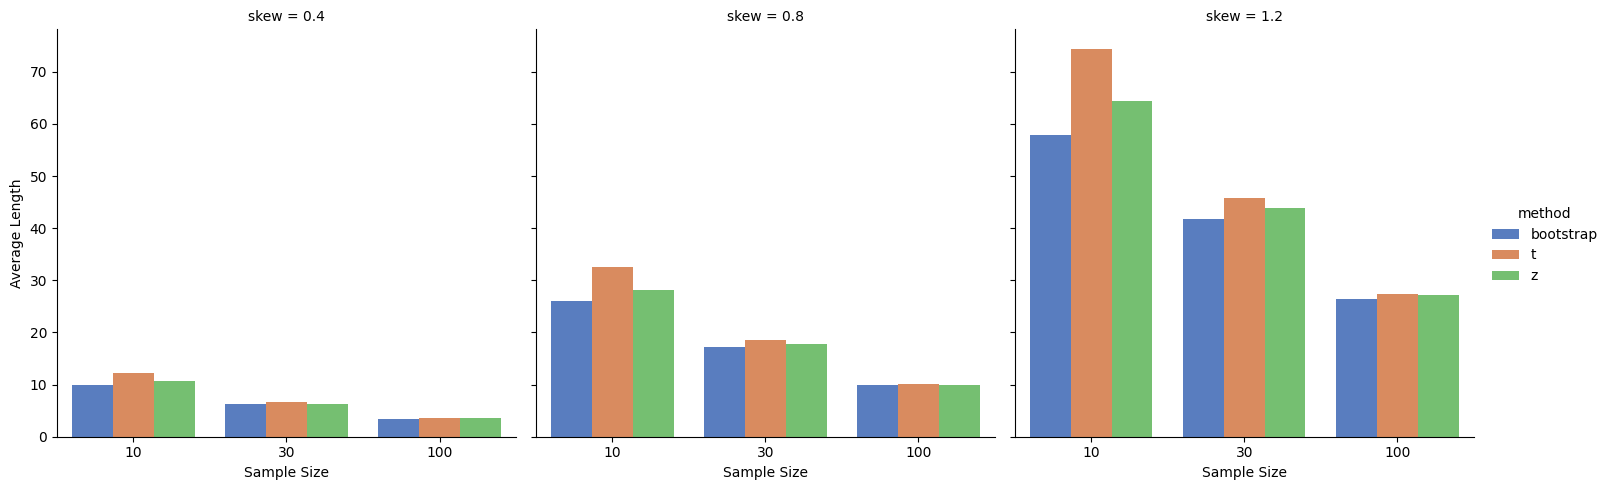

In [23]:
barplot_precision = sns.catplot(
    data=summary,
    x='n', 
    y='avg_width', 
    hue='method',
    col='skew',
    kind='bar',
    palette='muted',
    errorbar=None)

barplot_precision.set_axis_labels("Sample Size", "Average Length")

# Show plot
plt.show()

barplot_precision.savefig("barplot_precision.png", dpi=300, bbox_inches='tight')